# Overview

This notebook describes my program used in a competition from Kaggle, the [Santander Value Prediction Challenge](https://www.kaggle.com/c/santander-value-prediction-challenge#description). 

*"In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale"*.

The evaluation metric for this competition is *Root Mean Squared Logarithmic Error* (RMSLE). It is defined as

$$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i+1) - \log(y_i+1))^2},$$
where

$\epsilon$ is the RMSLE value,

$n$ is the total number of observations in the (public/private) data set,

$p_i$ is your prediction of target, and

$y_i$ is the actual target. 

A more insightful way to see the RMSLE is as
$$\epsilon = \frac{1}{\sqrt{n}} \left\| \log\left( \frac{p+1}{y+1} \right) \right\|_2.$$
$\| \ \|_2$ is the usual Euclidean norm. Taking $p+1$ instead of $p$ (and $y+1$ instead of $y$) guarantess that all terms in the sum are positive. With this we have a reasonable metric.

We will use several modules in this problem. Below we import all of them at once.

In [1]:
import numpy as np # linear algebra

import matplotlib.pyplot as plt # display images
from IPython.display import Image

import pandas as pd # data processing

from keras.models import Model # neural network generation, training and fitting
from keras.layers import Dense, Input
from keras.layers.merge import concatenate
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
def organize_data(X):
    """
    This function takes a bidimensional array X and sort every row in descending order.
    After this there will be some null columns to the right of X. These columns are them
    deleted.
    
    Input
    -----
    X: 2-D ndarray
    
    Output
    ------
    X: 2-D ndarray
    
    """
    
    max_non_null_terms = 0
    num_rows = X.shape[0]

    # Sort each row in descending order.  
    for i in range(0,num_rows):
        temp = np.array(sorted(X[i,:],reverse=True))
        X[i,:] = temp
        # We count the number of non null values in each row and keep the largest.
        non_null_terms = np.sum(X[i,:] > 0)
        if non_null_terms > max_non_null_terms:
            max_non_null_terms = non_null_terms
    
    # After sorting we "cut" the last columns which contains only null terms.
    X = X[:,0:max_non_null_terms]
    
    return X

In [3]:
def normalize_data(X):   
    """
    This function takes a bidimensional array X and normalize all its non zero entries,
    i.e., it computes the log10 of these entries.
    
    Input
    -----
    X: 2-D ndarray
    
    X_normalized: 2-D ndarray
    """
    
    # Normalize non-null entries.
    num_rows = X.shape[0]
    num_cols = X.shape[1]
    X_normalized = np.zeros((num_rows,num_cols), dtype = np.float64)
    for i in range(0,num_rows):
        for j in range(0,num_cols):
            if X[i,j] > 0:
                X_normalized[i,j] = np.log10(X[i,j])
    
    return X_normalized

# Preparing the data

Now we load the train and test datasets. The first two columns of the train dataset are not features, so we discard them when defining the input data **X**. The output data **Y** is set to be the target column.

In [4]:
# Load train and test dataset
train_data = pd.read_csv("train.csv")        
train_val = train_data.values
Y = train_val[:,1].astype(float)
X = train_val[:,2:].astype(float)

test_data = pd.read_csv("test.csv")        
test_val = test_data.values
X_test = test_val[:,1:].astype(float)

In [5]:
# View of the train dataset. We discard the ID column. The target column is the array Y.
train_data.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


As we can see, the input data is very sparse, being zero almost everywhere. Also we have much more features than instances, so we will have to deal with the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). These two things indicates we will have to deal with little information in a large dataset. In order to have more useful information about the dataset we discard these features by considering the row elements in descending order, so the features are *larger element, second larger element,* and so on. By doing this, we reduce the number of column from 4993 to 1994, which is a big reduction of dimension.

In [6]:
# stack vertically the train and test datasets
X_all = np.vstack((X, X_test))
# organize data
X_all = organize_data(X_all)
num_features = X_all.shape[1]
# normalize data
X_all = normalize_data(X_all)
Y = Y.reshape(Y.shape[0],1)
Y_normalized = normalize_data(Y)

# New features

We also introduce a few more features to have more information in the input dataset. These are showed below.

In [7]:
# add new features
num_new_features = 5
X_add = np.zeros((X_all.shape[0],num_features + num_new_features), dtype = np.float32)
for i in range(0,X_all.shape[0]):
    X_add[i,0] = np.mean(X_all[i,X_all[i,:]!=0])
    X_add[i,1] = np.min(X_all[i,X_all[i,:]!=0])
    X_add[i,2] = np.max(X_all[i,:])
    X_add[i,3] = np.sum(X_all[i,:] > 0)
    X_add[i,4] = np.std(X_all[i,:])
X_add[:,5:] = X_all

# update number of features
num_features = num_features + num_new_features

In [8]:
# split this new dataset in train and test datasets to be used in training and prediction stages
X_train_final = X_add[0:X.shape[0],:]
X_test_final = X_add[X.shape[0]:,:]

In [9]:
# Visualization of the new test dataset.
np.round(X_train_final[0:5,0:8],2)

array([[   6.46000004,    5.4000001 ,    7.5999999 ,  102.        ,
           1.42999995,    7.5999999 ,    7.5999999 ,    7.5999999 ],
       [   6.63000011,    5.9000001 ,    7.69999981,   67.        ,
           1.20000005,    7.69999981,    7.69999981,    7.51000023],
       [   6.38999987,    5.30000019,    7.07999992,   18.        ,
           0.61000001,    7.07999992,    7.07999992,    6.9000001 ],
       [   5.5999999 ,    3.29999995,    6.78000021,   22.        ,
           0.58999997,    6.78000021,    6.76000023,    6.76000023],
       [   6.40999985,    4.78000021,    7.57999992,   26.        ,
           0.73000002,    7.57999992,    7.57999992,    7.07999992]], dtype=float32)

# Neural network model description

We will use deep learning to solve this problem, which seems to be a very difficult nonlinear regression problem. Our model is a neural network with dense layers and concatenation. This model explores a new idea I had of reusing layers, interpreting them as someone who makes a job and right away receives feedback in order to redo the job better. This feedback is given by the **feeedback_hid** layer. This layer analyzes what the previous layers computed and produces a new input for these layers. This proccess of making computations over the input, analyzing the computations and producing new inputs is done several times. The idea is that the **feedback_hid** layer will simplify the input, keeping what is important for the *workers* (the previous hidden layers). After all this, the final input is passed to the **master** layer, which is a layer supposedly smarter. This layer is the last one before the output and the information goes through it only one time.

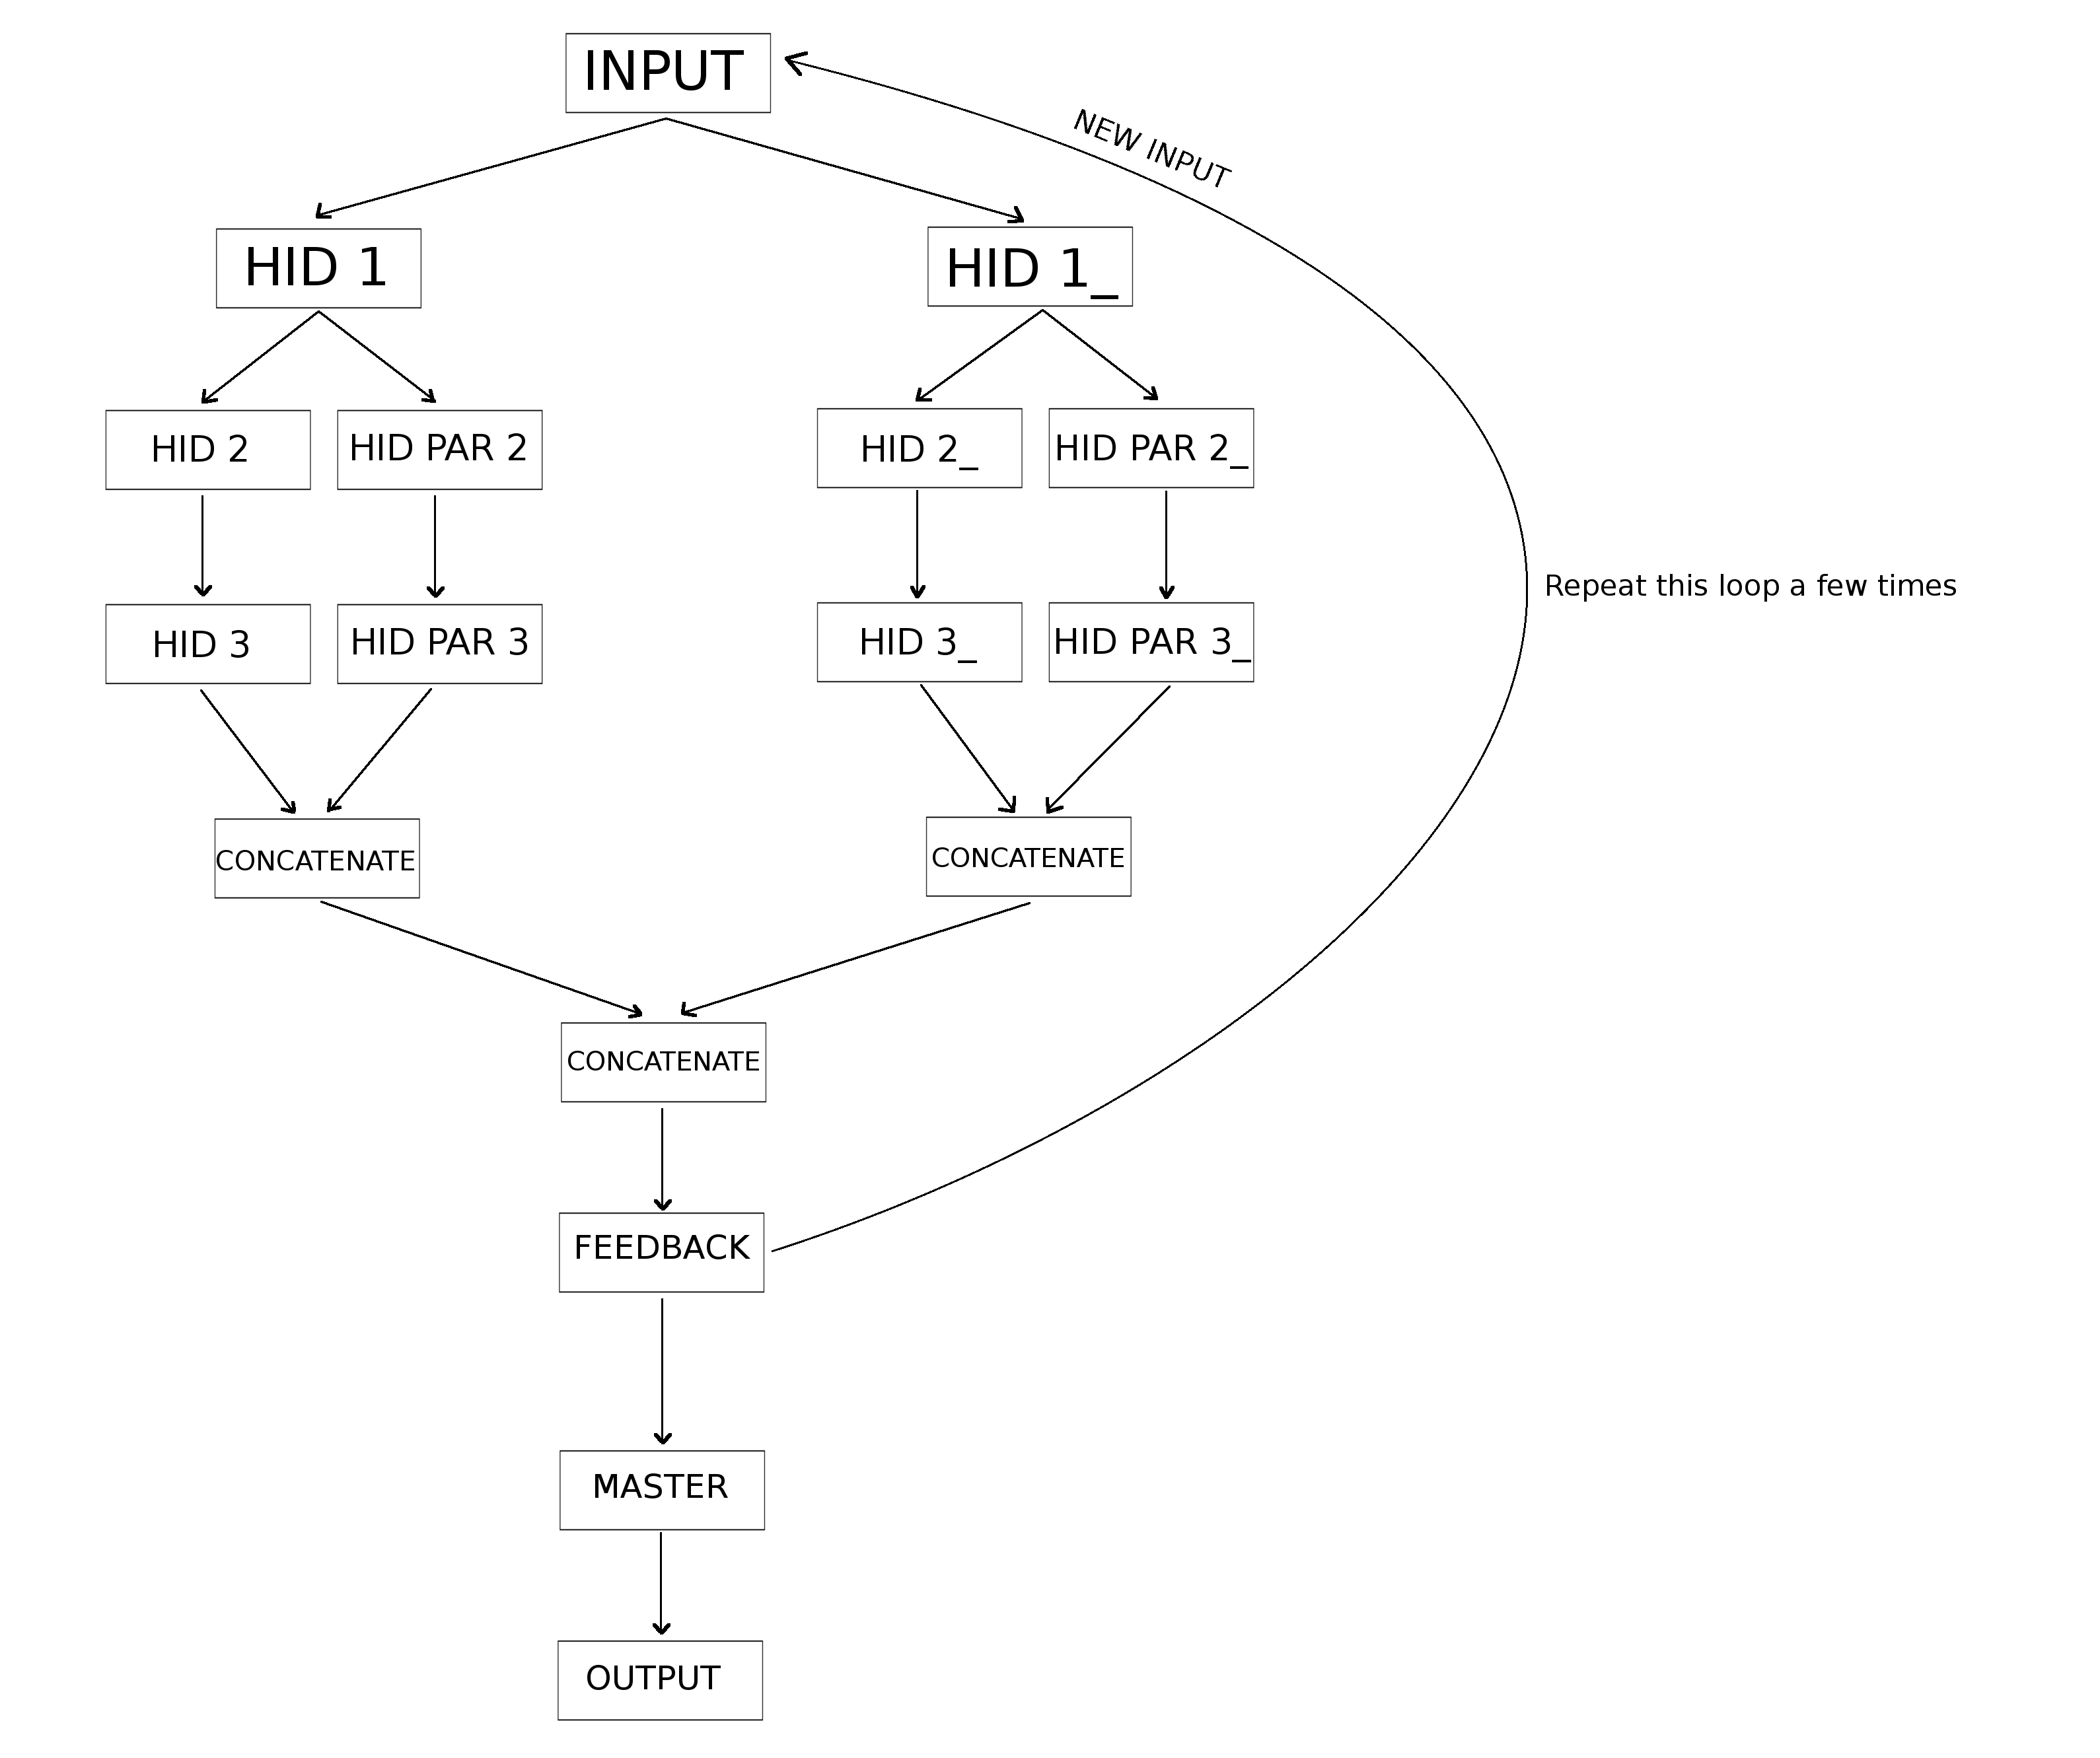

In [10]:
# Model illustration.
Image("model.png")

# Optimizing the parameters

We can make the loss function equals the metric RMSLE. In this case we don't need the metric parameter, i.e., the loss is the metric too.

Now it is the time to choose the number of neurons and cycles in our network (the number of cycles is the number of times the proccess described above is repeated, the computing and feedbacking proccess). We do this by making a search in grid on the number of neurons and cycles. The activation functions were choosed after a lot of trial and error, but you can try your own in order to improve the model. The activation functions were choosed after a lot of trial and error, but you can try your own in order to improve the model.

We split the train dataset in training set ($67\%$) and test set ($33\%$) in order to validate the model. The learning curves are plotted below and from them we can choose the best model.  

Cycles = 1
Neurons = 10

Loss of predictions in train dataset:
1.42896238307


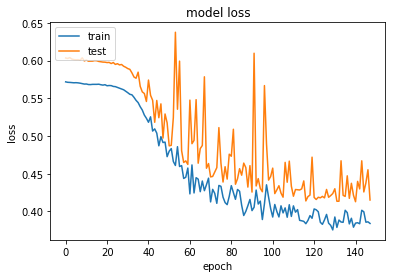

Cycles = 1
Neurons = 50

Loss of predictions in train dataset:
1.42762493218


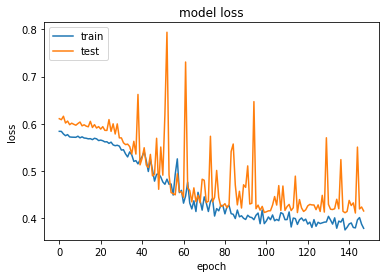

Cycles = 1
Neurons = 80

Loss of predictions in train dataset:
1.4066247629


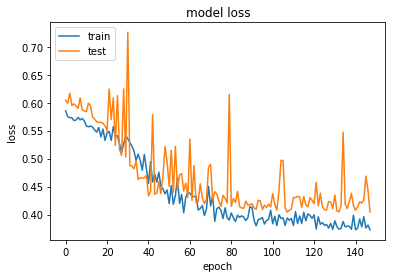

Cycles = 1
Neurons = 100

Loss of predictions in train dataset:
1.44455507383


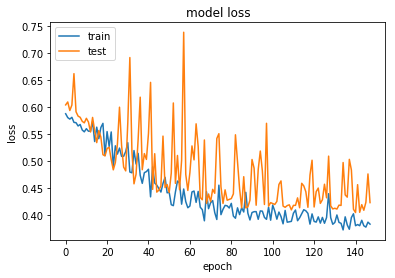

Cycles = 1
Neurons = 120

Loss of predictions in train dataset:
1.41469377462


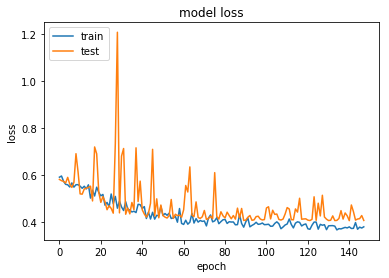

Cycles = 1
Neurons = 150

Loss of predictions in train dataset:
1.40495885603


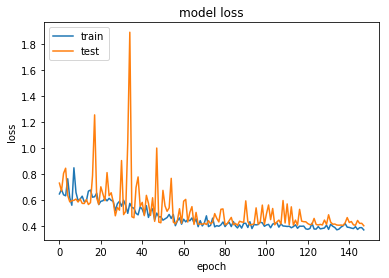

Cycles = 1
Neurons = 200

Loss of predictions in train dataset:
13.9077272749


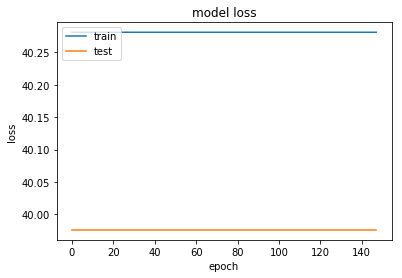

Cycles = 5
Neurons = 10

Loss of predictions in train dataset:
1.4329469082


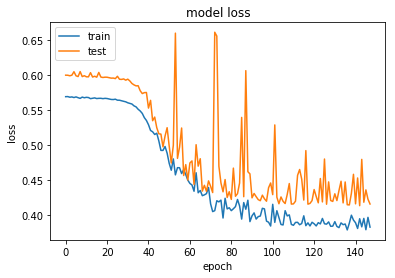

Cycles = 5
Neurons = 50

Loss of predictions in train dataset:
1.43616628336


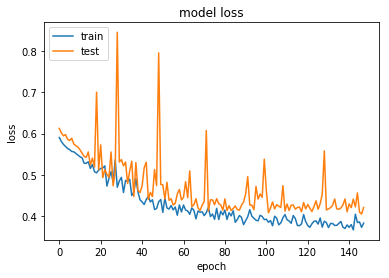

Cycles = 5
Neurons = 80

Loss of predictions in train dataset:
1.42416673771


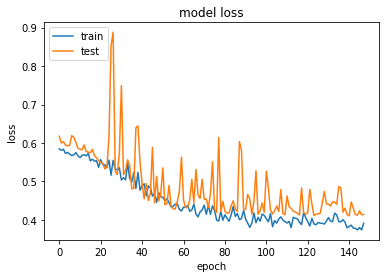

Cycles = 5
Neurons = 100

Loss of predictions in train dataset:
1.43825720054


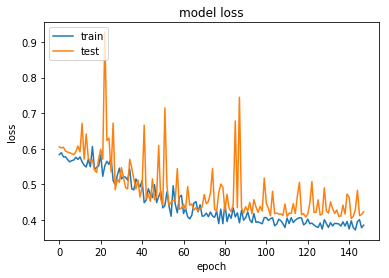

Cycles = 5
Neurons = 120

Loss of predictions in train dataset:
1.41438714844


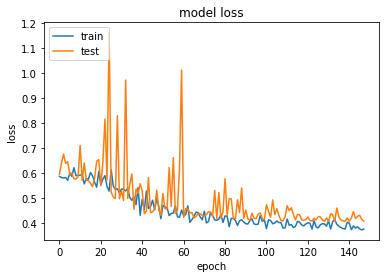

Cycles = 5
Neurons = 150

Loss of predictions in train dataset:
1.42796526849


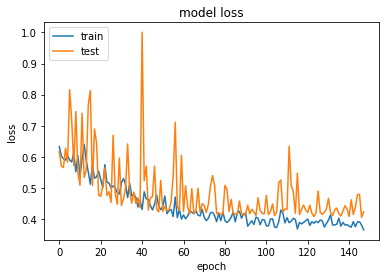

Cycles = 5
Neurons = 200

Loss of predictions in train dataset:
13.9077272749


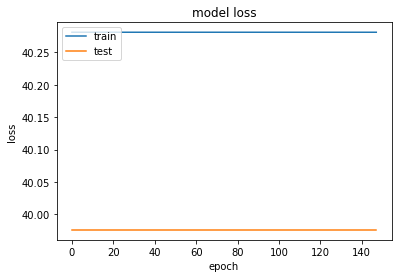

Cycles = 10
Neurons = 10

Loss of predictions in train dataset:
1.45064930825


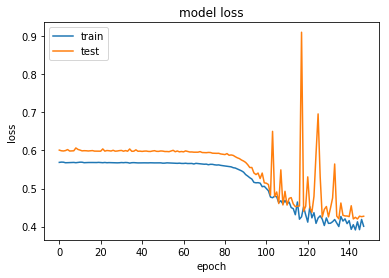

Cycles = 10
Neurons = 50

Loss of predictions in train dataset:
1.4700652767


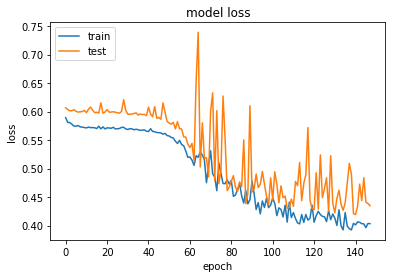

Cycles = 10
Neurons = 80

Loss of predictions in train dataset:
1.43708183583


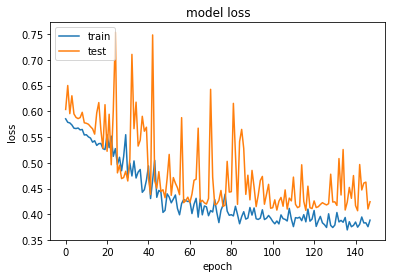

Cycles = 10
Neurons = 100

Loss of predictions in train dataset:
1.58362527506


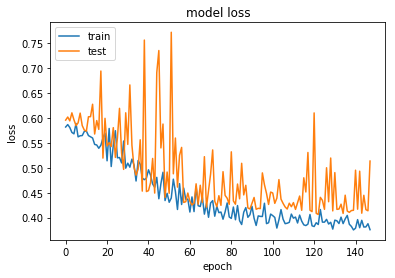

Cycles = 10
Neurons = 120

Loss of predictions in train dataset:
1.40784484273


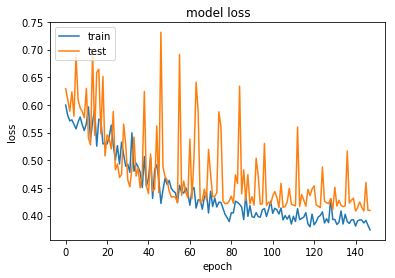

Cycles = 10
Neurons = 150

Loss of predictions in train dataset:
1.4127260562


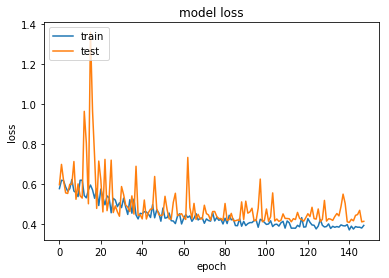

Cycles = 10
Neurons = 200

Loss of predictions in train dataset:
13.9077246617


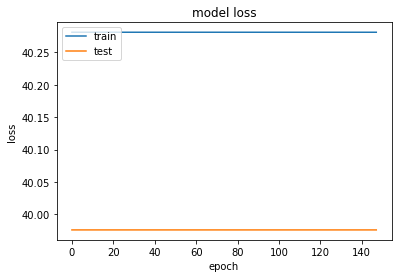

Cycles = 15
Neurons = 10

Loss of predictions in train dataset:
1.46215226099


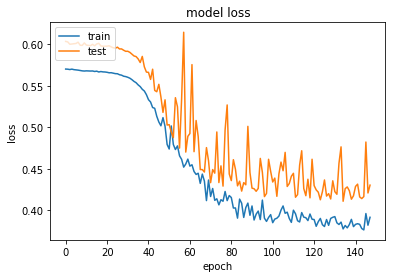

Cycles = 15
Neurons = 50

Loss of predictions in train dataset:
1.48141424695


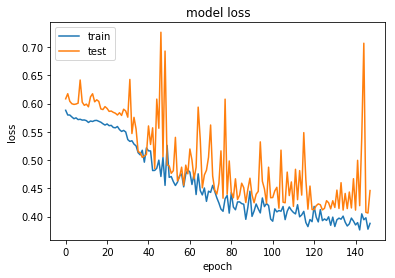

Cycles = 15
Neurons = 80

Loss of predictions in train dataset:
1.52535295335


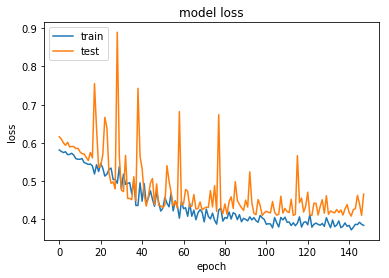

Cycles = 15
Neurons = 100

Loss of predictions in train dataset:
1.42440254825


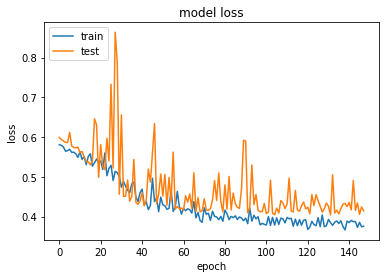

Cycles = 15
Neurons = 120

Loss of predictions in train dataset:
1.48759858596


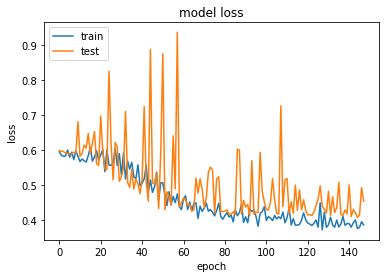

Cycles = 15
Neurons = 150

Loss of predictions in train dataset:
1.4119654257


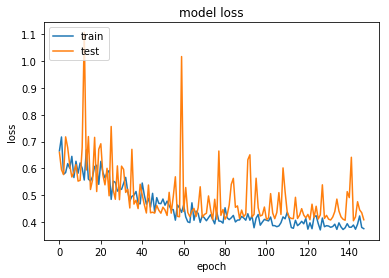

Cycles = 15
Neurons = 200

Loss of predictions in train dataset:
13.9077272717


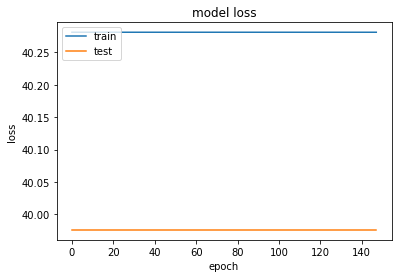

Cycles = 20
Neurons = 10

Loss of predictions in train dataset:
1.56779994169


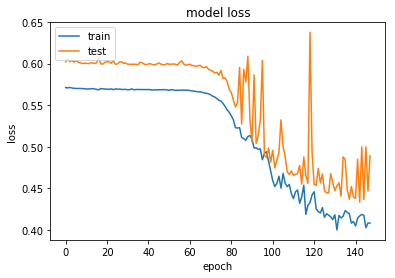

Cycles = 20
Neurons = 50

Loss of predictions in train dataset:
1.43593048534


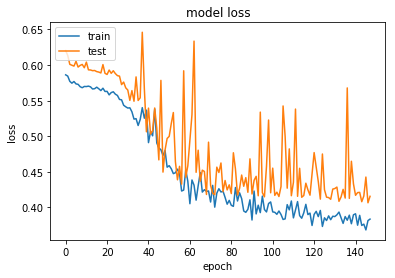

Cycles = 20
Neurons = 80

Loss of predictions in train dataset:
1.40970974791


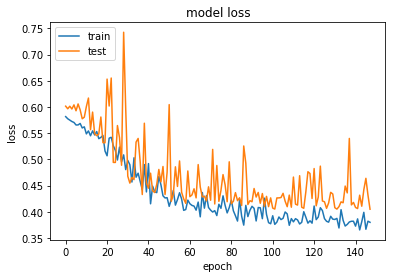

Cycles = 20
Neurons = 100

Loss of predictions in train dataset:
1.41888644108


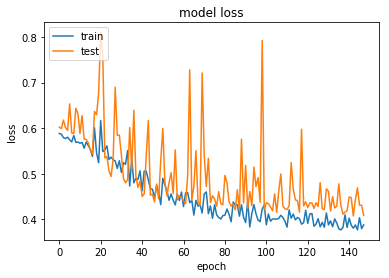

Cycles = 20
Neurons = 120

Loss of predictions in train dataset:
1.4728004242


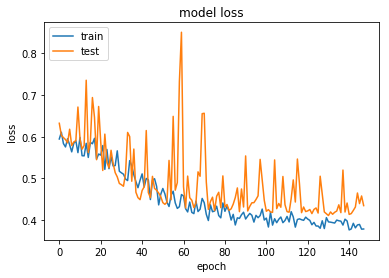

Cycles = 20
Neurons = 150

Loss of predictions in train dataset:
1.43364962108


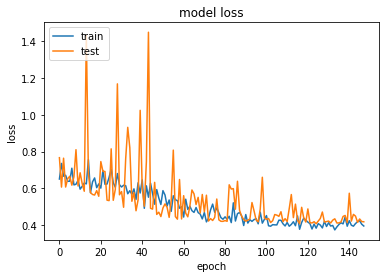

Cycles = 20
Neurons = 200

Loss of predictions in train dataset:
13.9077272665


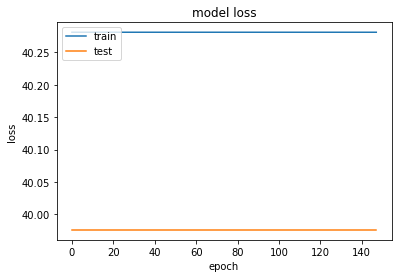

In [12]:
# Check learning plots to see if the model is overfitting or not, if it is learning or not. 
# Now it is the time we choose the best parameters.
for cycles in [1,5,10,15,20]:
    for neurons in [10,50,80,100,120,150,200]:
        # input layer
        visible = Input(shape=(num_features,))
        # first feature extractor
        hid1 = Dense(neurons, kernel_initializer='normal', activation = "tanh")
        hid2 = Dense(neurons, kernel_initializer='normal', activation = "relu")
        hidpar2 = Dense(neurons, kernel_initializer='normal', activation = "tanh")
        hid3 = Dense(neurons, kernel_initializer='normal', activation = "relu")
        hidpar3 = Dense(neurons, kernel_initializer='normal', activation = "tanh")
        # second feature extractor
        hid1_ = Dense(neurons, kernel_initializer='normal', activation = "relu")
        hid2_ = Dense(neurons, kernel_initializer='normal', activation = "tanh")
        hidpar2_ = Dense(neurons, kernel_initializer='normal', activation = "relu")
        hid3_ = Dense(neurons, kernel_initializer='normal', activation = "tanh")
        hidpar3_ = Dense(neurons, kernel_initializer='normal', activation = "relu")
        # interpretation layer
        feedback_hid = Dense(num_features, kernel_initializer='normal', activation = "relu")
    
        x = visible
        L = []
        LP = []
        for i in range(0,cycles):
            # first path (L = layer)
            L.append(hid1(x))
            L.append(hid2(L[0]))
            L.append(hidpar2(L[1]))
            L.append(hid3(L[2]))
            L.append(hidpar3(L[3]))
            L.append(concatenate([L[3],L[4]]))
            # second path (LP = layer in parallel)
            LP.append(hid1_(x))
            LP.append(hid2_(LP[0]))
            LP.append(hidpar2_(LP[1]))
            LP.append(hid3_(LP[2]))
            LP.append(hidpar3_(LP[3]))
            LP.append(concatenate([LP[3],LP[4]]))
            # merge both paths
            final_merge = concatenate([L[-1],LP[-1]])        
            x = feedback_hid(final_merge)
        
        # prediction output
        master = Dense(neurons, kernel_initializer='normal', activation='tanh')(x)
        output = Dense(1, kernel_initializer='normal', activation='softplus')(master)
        model = Model(inputs=visible, outputs=output)
        
        # compile the network
        sgd = SGD(lr=0.01, momentum=0.1, decay=0.0, nesterov=False)
        model.compile(loss='mean_squared_error', optimizer=sgd)

        # fit the model
        history = model.fit(X_train_final, Y_normalized,validation_split=0.33, epochs=150, batch_size=100, verbose=0)
        print('Cycles =',cycles)
        print('Neurons =', neurons)
        # show some information about the predictions
        print('\nLoss of predictions in train dataset:')
        predictions = model.predict(X_train_final)
        # Transform predictions to original format
        predictions = 10**predictions
        print( np.sqrt(1/Y.shape[0])*np.linalg.norm((np.log(predictions+1)-np.log(Y+1)),2) )

        # summarize history for loss
        plt.plot(history.history['loss'][2:])
        plt.plot(history.history['val_loss'][2:])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

For **cycles** $\geq 10$ we can see the model starting to overfit. In the other cases the test loss curve (orange curve) has a lot of peaks, which means the model can make big errors sometimes. The only exception to this is when we have **cycles** $=5$ and **neurons** $=150$. This seems to be the best option. 

Now, the last step in this testing stage is to determine how many epochs we should be using. The number of epochs is not that significant. More important is the validation error. As long as it keeps dropping, training should continue. With this in mind we test a range of epochs, keep the one with the best results (which should be reliable now with a larger batch size) taking into account the rate of convergence. In other words, we want a large epoch in order to converge, but not too much large in the sense we don't want to spend time to gain tiny accuracy.

We keep the batch size equal to $100$ so the validation is more reliable. This choice probably will lead us to use more epochs.

In [15]:
# final model
cycles = 5
neurons = 150

# input layer
visible = Input(shape=(num_features,))
# first feature extractor
hid1 = Dense(neurons, kernel_initializer='normal', activation = "tanh")
hid2 = Dense(neurons, kernel_initializer='normal', activation = "relu")
hidpar2 = Dense(neurons, kernel_initializer='normal', activation = "tanh")
hid3 = Dense(neurons, kernel_initializer='normal', activation = "relu")
hidpar3 = Dense(neurons, kernel_initializer='normal', activation = "tanh")
# second feature extractor
hid1_ = Dense(neurons, kernel_initializer='normal', activation = "relu")
hid2_ = Dense(neurons, kernel_initializer='normal', activation = "tanh")
hidpar2_ = Dense(neurons, kernel_initializer='normal', activation = "relu")
hid3_ = Dense(neurons, kernel_initializer='normal', activation = "tanh")
hidpar3_ = Dense(neurons, kernel_initializer='normal', activation = "relu")
# interpretation layer
feedback_hid = Dense(num_features, kernel_initializer='normal', activation = "relu")
    
x = visible
L = []
LP = []
for i in range(0,cycles):
    # first path (L = layer)
    L.append(hid1(x))
    L.append(hid2(L[0]))
    L.append(hidpar2(L[1]))
    L.append(hid3(L[2]))
    L.append(hidpar3(L[3]))
    L.append(concatenate([L[3],L[4]]))
    # second path (LP = layer in parallel)
    LP.append(hid1_(x))
    LP.append(hid2_(LP[0]))
    LP.append(hidpar2_(LP[1]))
    LP.append(hid3_(LP[2]))
    LP.append(hidpar3_(LP[3]))
    LP.append(concatenate([LP[3],LP[4]]))
    # merge both paths
    final_merge = concatenate([L[-1],LP[-1]])        
    x = feedback_hid(final_merge)
        
# prediction output
master = Dense(neurons, kernel_initializer='normal', activation='tanh')(x)
output = Dense(1, kernel_initializer='normal', activation='softplus')(master)
model = Model(inputs=visible, outputs=output)
        
# compile the network
sgd = SGD(lr=0.01, momentum=0.1, decay=0.0, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd)

# Fitting and predicting

The network **model** has two methods we will be using: the **fit** and the **predict** methods. The first is the one which actually trains the neural network. Its inputs are the train dataset **X_train_final** and the corresponding output dataset **Y_normalized**. After the training is complete, we call the **predict** method with input **X_train_final**. Note that, by doing this, we are seeing how the model fits in the train dataset, not the test dataset. The general idea is: the model was trained using the train dataset and, at least, it should fit well in its own train dataset. 

Notice that the array **predictions** was obtained using normalized data. The original format is $10$ to the power of **predictions**. The last line is the RMSLE over the original train dataset. This is the real metric when want to minimize (but we must be careful to not overfit).

Epoch 1/150
 - 5s - loss: 3.6475
Epoch 2/150
 - 1s - loss: 0.6160
Epoch 3/150
 - 1s - loss: 0.6092
Epoch 4/150
 - 1s - loss: 0.6034
Epoch 5/150
 - 1s - loss: 0.7056
Epoch 6/150
 - 1s - loss: 0.6479
Epoch 7/150
 - 1s - loss: 0.6470
Epoch 8/150
 - 1s - loss: 0.6308
Epoch 9/150
 - 1s - loss: 0.6254
Epoch 10/150
 - 1s - loss: 0.6850
Epoch 11/150
 - 1s - loss: 0.6054
Epoch 12/150
 - 1s - loss: 0.6647
Epoch 13/150
 - 1s - loss: 0.6928
Epoch 14/150
 - 1s - loss: 0.6148
Epoch 15/150
 - 1s - loss: 0.6429
Epoch 16/150
 - 1s - loss: 0.5962
Epoch 17/150
 - 1s - loss: 0.6452
Epoch 18/150
 - 1s - loss: 0.6505
Epoch 19/150
 - 1s - loss: 0.6331
Epoch 20/150
 - 1s - loss: 0.5975
Epoch 21/150
 - 1s - loss: 0.6732
Epoch 22/150
 - 1s - loss: 0.6233
Epoch 23/150
 - 1s - loss: 0.6554
Epoch 24/150
 - 1s - loss: 0.6023
Epoch 25/150
 - 1s - loss: 0.6241
Epoch 26/150
 - 1s - loss: 0.5992
Epoch 27/150
 - 1s - loss: 0.5941
Epoch 28/150
 - 1s - loss: 0.5974
Epoch 29/150
 - 1s - loss: 0.5453
Epoch 30/150
 - 1s - lo

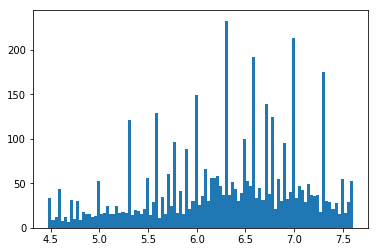

Predictions of the train dataset outputs.


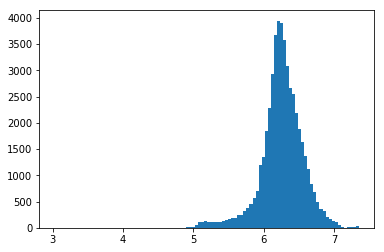

In [16]:
# fit the model to make predictions over the test dataset
history = model.fit(X_train_final, Y_normalized, epochs=150, batch_size=100, verbose=2)

# since X has more columns than X_test, we fill X_test with more null columns
predictions = model.predict(X_test_final)

# We plot some histogram to visualize the distribution of the predictions and make some comparisons. We expect
#that the histogram of the predictions are similar to the histogram of the outputs in the train dataset.
predictions = 10**predictions

print('Train dataset outputs.')
plt.hist(np.log10(Y),bins=100)
plt.show()

print('Predictions of the train dataset outputs.')
plt.hist(np.log10(predictions),bins=100)
plt.show()

The last thing we have to do is to save our predictions. First we open the file with the model format to save. Now just change the column *target* (which is randomly in the file *sample_submission.csv*), updating with our new predictions. Now save a new file, which we name *submission.csv*. Finally, we print the head of this file just to hane an idea of how it looks.

With these predictions it is possible to score $1.4$ in this Kaggle's competition.

In [17]:
# Save these predictions.
submission = pd.read_csv('sample_submission.csv')
submission["target"] = predictions
submission.to_csv('submission.csv', index=False)
print(submission.head())

          ID       target
0  000137c73  1349576.500
1  00021489f  1442105.625
2  0004d7953  1117911.875
3  00056a333  2199757.500
4  00056d8eb  1476632.500
